In [89]:
# Wczytać dane netflixa
# Stworzyć grafy reżyserzy aktorzy
# similarity matrix
# heat map

In [90]:
import pandas as pd
filename = 'Graph2Vec//netflix_titles.csv' 
df = pd.read_csv(filename)
print(df.shape[0])
df.head()

7787


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [195]:
df=df[~(df.cast.isnull() | df.director.isnull())]
df=df.assign(cast=df['cast'].str.split(', ')).explode('cast')
df=df.assign(director=df['director'].str.split(', ')).explode('director')
# df=df[df["director"]!=df['cast']]
print(df.shape[0])
df.head()

43959


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,Movie,7:19,Jorge Michel Grau,Demián Bichir,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Héctor Bonilla,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Oscar Serrano,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Azalia Ortiz,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
1,s2,Movie,7:19,Jorge Michel Grau,Octavio Michel,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


In [208]:
import networkx as nx
def createGraph(df):
    G = nx.Graph()
    nodes = [(i, {"feature": actor}) for i,actor in enumerate(df.cast)]
    G.add_nodes_from(nodes)
    G.add_nodes_from([(len(nodes),{"feature": df["director"].values[0]})])
    G.add_edges_from([(df.shape[0],i) for i in range(df.shape[0])])
    attributes = {i:actor for i,actor in enumerate(df.cast)}
    attributes[len(nodes)]=df["director"].values[0]
    nx.set_node_attributes(G, attributes, "feature")
    return G
    
df_grouped_by_directors = [b for _,b in df.groupby("director")]
graphs = [createGraph(b) for b in df_grouped_by_directors]

In [209]:
def check(graph):
    numeric_indices = [index for index in range(graph.number_of_nodes())]
    print(numeric_indices)
    node_indices = sorted([node for node in graph.nodes()])
    print(node_indices)
    return numeric_indices == node_indices, "The node indexing is wrong."

In [210]:
check(graphs[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


(True, 'The node indexing is wrong.')

In [212]:
from karateclub.graph_embedding import Graph2Vec
model = Graph2Vec(attributed=True)
model.fit(graphs)
model.get_embedding()

/home/vergenter/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")


array([[-2.91380309e-03, -1.35324663e-03, -1.03664761e-05, ...,
        -2.17152364e-03,  2.86015944e-04,  4.88539401e-04],
       [-2.99250358e-03, -2.53576483e-03, -2.06718012e-03, ...,
         2.69725895e-03,  9.88913816e-04, -7.18324329e-04],
       [ 2.08024913e-03,  6.45328662e-04,  1.21518492e-03, ...,
         2.35074526e-03, -2.36135558e-03, -2.73377635e-03],
       ...,
       [ 1.35444594e-03, -3.52715421e-03, -1.82645943e-03, ...,
        -1.03303546e-03, -4.48897568e-04,  1.96003541e-03],
       [-3.22611211e-03, -3.81857087e-03,  2.69583846e-03, ...,
        -8.86123336e-04, -2.15336075e-03,  1.11729154e-04],
       [ 1.41963450e-04, -2.51418655e-03,  3.18219396e-03, ...,
        -3.70316952e-03, -1.95360044e-03,  1.52877939e-03]], dtype=float32)

In [213]:
np.shape(model.get_embedding())

(4061, 128)

In [214]:
from scipy.spatial.distance import pdist,squareform
distances = squareform(pdist(np.array(model.get_embedding())))

In [249]:
distances[:5,:5]

array([[0.        , 0.0347964 , 0.0361065 , 0.03256572, 0.03500944],
       [0.0347964 , 0.        , 0.03670608, 0.03718825, 0.03738989],
       [0.0361065 , 0.03670608, 0.        , 0.03962798, 0.03786426],
       [0.03256572, 0.03718825, 0.03962798, 0.        , 0.03359871],
       [0.03500944, 0.03738989, 0.03786426, 0.03359871, 0.        ]])

In [245]:
from numba import njit,int64
@njit
def find_n_smallest_values(ndarray_2, n_values,skip=0):
    indices = np.zeros((n_values,2),dtype=int64)
    smallest = np.ones(n_values) * np.inf
    for i in range(ndarray_2.shape[0]):
        for j in range(ndarray_2.shape[1]):
            if ndarray_2[i][j] != skip:
                for k in range(n_values+1):
                    if k != n_values and ndarray_2[i][j]<smallest[k]:
                        continue
                    if k == 0:
                        break
                    for l in range(k-1):
                        indices[l][0]=indices[l+1][0]
                        indices[l][1]=indices[l+1][1]
                        smallest[l]=smallest[l+1]
                    indices[k-1][0]=i
                    indices[k-1][1]=j
                    smallest[k-1]=ndarray_2[i][j]
                    break
    return indices   

In [246]:
test_table = np.array([[0,0,0],[1,2,3],[2,3,4],[3,4,5]])
res = find_n_smallest_values(test_table,5)
print([test_table[ind[0]][ind[1]] for ind in res])

[3, 3, 2, 2, 1]


In [247]:
most_similar = find_n_smallest_values(distances,20)[1::2] # distance are pairwise then skip odds

In [248]:
for indices in most_similar:
    print("director 1:",df_grouped_by_directors[indices[0]].director.values[0])
    print(df_grouped_by_directors[indices[0]].cast.values)
    print("director 2:",df_grouped_by_directors[indices[1]].director.values[0])
    print(df_grouped_by_directors[indices[1]].cast.values)
    print()
    

director 1: Robert Clouse
['Bruce Lee' 'John Saxon' 'Jim Kelly' 'Ahna Capri' 'Kien Shih'
 'Robert Wall' 'Angela Mao' 'Betty Chung' 'Geoffrey Weeks' 'Bolo Yeung'
 'Peter Archer']
director 2: Ryuichi Yagi
['Takeru Sato' 'Kasumi Arimura' 'Haru' 'Kentaro Sakaguchi'
 'Takayuki Yamada' 'Kendo Kobayashi' 'Ken Yasuda' 'Arata Furuta'
 'Suzuki Matsuo' 'Koichi Yamadera' 'Arata Iura' 'Chikako Kaku'
 'Kotaro Yoshida']

director 1: Ali Samadi Ahadi
['Stefan Kurt' 'Marianne Sägebrecht' 'Max Herbrechter']
director 2: David M. Rosenthal
['Theo James' 'Forest Whitaker' 'Kat Graham' 'Nicole Ari Parker'
 "Mark O'Brien" 'Grace Dove' 'Michael Ealy' 'Jesse Williams'
 'Nicole Beharie' 'Guy Burnet' 'Joseph Sikora' 'Karla Souza'
 'Ritchie Coster' 'Jon Eyez']

director 1: Jared Hess
['Sam Rockwell' 'Amy Ryan' 'Will Forte' 'Danny McBride' 'Jemaine Clement'
 'Leslie Bibb' 'Steve Park' 'Sky Elobar' 'P.J. Boudousqué' 'Yaniv Moyal'
 'Jack Black' 'Ana de la Reguera' 'Héctor Jiménez' 'Darius Rose'
 'Moises Arias' 'Dieg

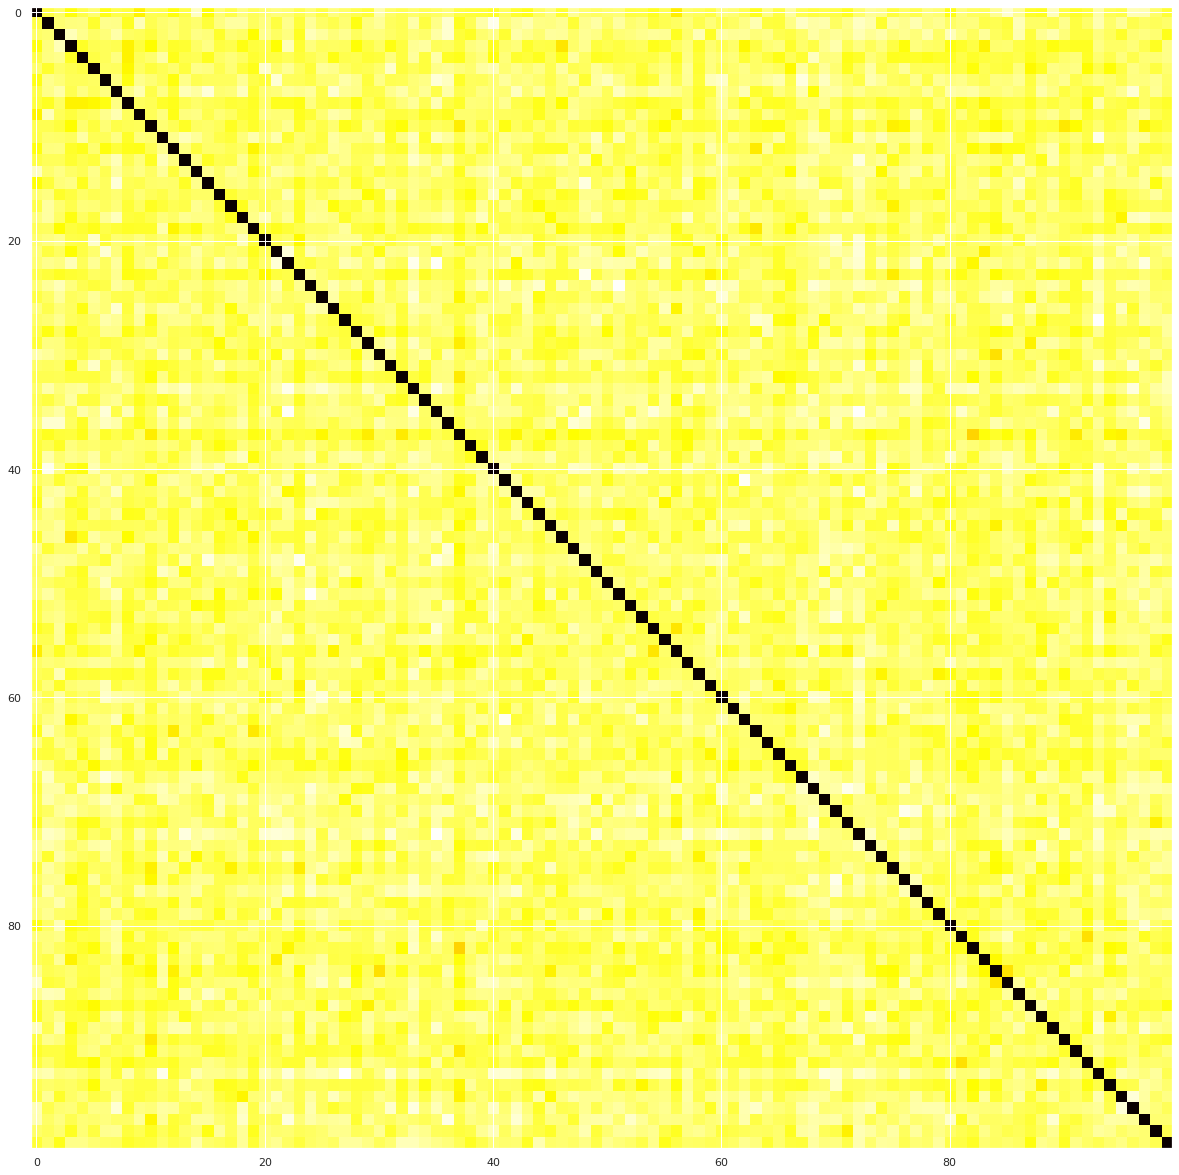

In [250]:
plt.figure(figsize=(21,21))
plt.imshow(distances[:100,:100], cmap='hot')

In [223]:
import networkx as nx
from karateclub.graph_embedding import Graph2Vec

# Graph2Vec attributed example

graphs = []

for i in range(50):
    graph = nx.newman_watts_strogatz_graph(50, 5, 0.3)
    nx.set_node_attributes(graph, {j: str(j) for j in range(50)}, "feature")
    graphs.append(graph)
model = Graph2Vec(attributed=True)

model.fit(graphs)
model.get_embedding()


# Graph2Vec generic example

graphs = [nx.newman_watts_strogatz_graph(50, 5, 0.3) for _ in range(1000)]

model = Graph2Vec()

model.fit(graphs)
model.get_embedding()

/home/vergenter/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:315: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")


array([[ 0.00696738, -0.05681495,  0.00811942, ..., -0.03874161,
         0.02289277, -0.04707823],
       [ 0.00790184, -0.06126606,  0.00610925, ..., -0.03640383,
         0.0250558 , -0.05179067],
       [ 0.01343524, -0.05940631,  0.00976055, ..., -0.03755679,
         0.02242495, -0.0554034 ],
       ...,
       [ 0.01025409, -0.05498619,  0.01085543, ..., -0.0329295 ,
         0.02444539, -0.04920947],
       [ 0.0141275 , -0.06073234,  0.00559563, ..., -0.03583764,
         0.02224053, -0.04819869],
       [ 0.01241803, -0.06006369,  0.00844025, ..., -0.0413798 ,
         0.02607889, -0.05211928]], dtype=float32)

In [3]:
import numpy as np
np.shape(model.get_embedding())

(1000, 128)